# Assignment: Use CNN to do image classification
Author: Long M. Luu

In [1]:
%%capture
!pip install tensorflow --upgrade
# Upgrade tensorflow from 2.2 to 2.3

In [2]:
# Load dataset CIFAR 10, source: https://www.cs.toronto.edu/~kriz/cifar.html
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
# Classes of CIFAR 10
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

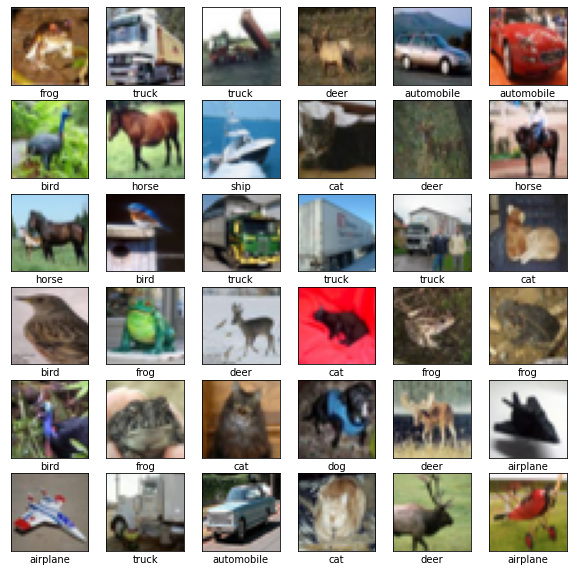

In [4]:
# Show the image with the corresponding label
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(36): # Plot 36 images
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # START CODE HERE
    plt.imshow(x_train[i], cmap=plt.cm.binary) 
    plt.xlabel(classes[y_train[i][0]])
    # END CODE HERE
plt.show()

In [5]:
# Split dataset into train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train/255.0, y_train, test_size=0.2, shuffle=True, random_state=42)

In [6]:
# Check shape
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 1)
(10000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [7]:
# Normalize test data
x_test = x_test / 255.0

In [19]:
"""
TODO 1: Create Feedforward model as follows (suggested):
Flatten(), input_shape=(32, 32, 3)
First layer: 1024, activation tanh
Dropout layer: 0.42
Second layer: 512, activation tanh
Dropout layer: 0.42
Third layer: 256, activation tanh
Fourth layer: 10, activation softmax
"""
from tensorflow.keras.layers import Flatten, Dense, Dropout
def create_fnn_model():
    # START CODE HERE
    model = tf.keras.Sequential([
        Flatten(input_shape=(32, 32, 3)),                         
        Dense(1024, activation="tanh"),
        Dropout(0.42),
        Dense(512, activation="tanh"),
        Dropout(0.42),
        Dense(256, activation="tanh"),
        Dense(10, activation="softmax")
    ])
    # END CODE HERE
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

fnn_model = create_fnn_model()
fnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 10)               

In [22]:
epochs=20
"""
Early Stopping callback
monitor: metrics that the Callback will watch
patience: integer, after n epochs if the monitor value does not improve, stop training
restore_best_weights: boolean, restore weights when monitor value is highest
"""
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=epochs//5, restore_best_weights=True)

In [23]:
# Train the model
fnn_model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_valid, Y_valid), callbacks=[early_stop])

Epoch 1/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1374 - accuracy: 0.1641 - val_loss: 2.0875 - val_accuracy: 0.1770
Epoch 2/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1422 - accuracy: 0.1642 - val_loss: 2.1253 - val_accuracy: 0.1520
Epoch 3/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1340 - accuracy: 0.1649 - val_loss: 2.0942 - val_accuracy: 0.1661
Epoch 4/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1333 - accuracy: 0.1629 - val_loss: 2.0834 - val_accuracy: 0.1735
Epoch 5/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1356 - accuracy: 0.1645 - val_loss: 2.1139 - val_accuracy: 0.1451
Epoch 6/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1334 - accuracy: 0.1614 - val_loss: 2.0997 - val_accuracy: 0.1683
Epoch 7/20
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1326 - accuracy: 0.1645 - val_loss: 2.1015 - val_accuracy:

In [24]:
# Evaluate the model
fnn_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.0843 - accuracy: 0.1742


[2.084338665008545, 0.17419999837875366]

### It is clear that even with a lot of parameters, FNN cannot perform well (accuracy is pretty low), let's try CNN

In [27]:
"""
TODO 2: create a CNN model as follows:
Conv2D, 32 filters, kernel size (5, 5), input shape = (32, 32, 3), same padding
BatchNorm
Activation: relu
MaxPooling2D, same padding
Conv2D, 64 filters, kernel size (5, 5), same padding
BatchNorm
Activation: relu
MaxPooling2D, same padding
Dropout 0.42
Conv2D, 128 filters, kernel size (3, 3), valid padding
BatchNorm
MaxPooling2D, same padding
Flatten
Dropout, rate 0.42
Dense, 256 nodes, activation tanh
Dense, 128 nodes, activation tanh
Dense, 10 nodes, activation softmax
"""
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Dropout, Flatten, Activation

def create_cnn_model():
    model = tf.keras.Sequential([
        Conv2D(32, (5, 5), input_shape=(32, 32, 3), padding="same"),
        BatchNormalization(),
        Activation("relu"),
        MaxPool2D(),
        Conv2D(64, (5, 5), padding="same"),
        BatchNormalization(),
        Activation("relu"),
        MaxPool2D(),
        Dropout(0.42),
        Conv2D(128, (3, 3)),
        BatchNormalization(),
        MaxPool2D(padding="same"),
        Flatten(),
        Dropout(0.42),
        Dense(256, activation="tanh"),
        Dense(128, activation="tanh"),
        Dense(10, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 16, 16, 64)       

In [28]:
# Train the model, recall that epochs = 50
history = cnn_model.fit(X_train, Y_train, batch_size=32, epochs=20, 
                        validation_data=(X_valid, Y_valid), callbacks=[early_stop])

Epoch 1/20
1250/1250 [==============================] - 11s 9ms/step - loss: 1.5300 - accuracy: 0.4392 - val_loss: 1.6622 - val_accuracy: 0.4262
Epoch 2/20
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2390 - accuracy: 0.5532 - val_loss: 1.6256 - val_accuracy: 0.4666
Epoch 3/20
1250/1250 [==============================] - 11s 9ms/step - loss: 1.1094 - accuracy: 0.6041 - val_loss: 1.0247 - val_accuracy: 0.6322
Epoch 4/20
1250/1250 [==============================] - 11s 9ms/step - loss: 1.0289 - accuracy: 0.6374 - val_loss: 1.5037 - val_accuracy: 0.5469
Epoch 5/20
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9621 - accuracy: 0.6602 - val_loss: 1.1529 - val_accuracy: 0.6125
Epoch 6/20
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9198 - accuracy: 0.6771 - val_loss: 1.4430 - val_accuracy: 0.5358
Epoch 7/20
1250/1250 [==============================] - 11s 9ms/step - loss: 0.8811 - accuracy: 0.6903 - val_loss: 1.0889 - val_ac

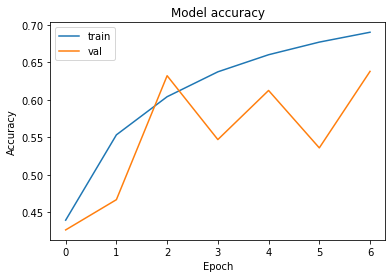

In [29]:
# Plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

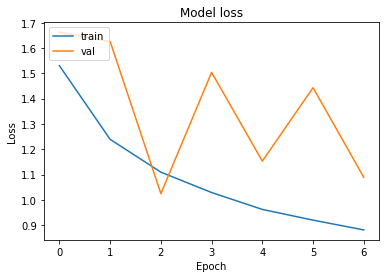

In [30]:
# Plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

In [31]:
# Evaluate the model
# Global result: https://paperswithcode.com/sota/image-classification-on-cifar-10
eval = cnn_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 5ms/step - loss: 1.0292 - accuracy: 0.6417


CNN with less paramters (but longer training time), performs a lot better than FNN. Let's see the wrong predictions

In [32]:
import numpy as np

prediction = cnn_model.predict(x_test)
label_prediction = np.argmax(prediction, axis=-1)

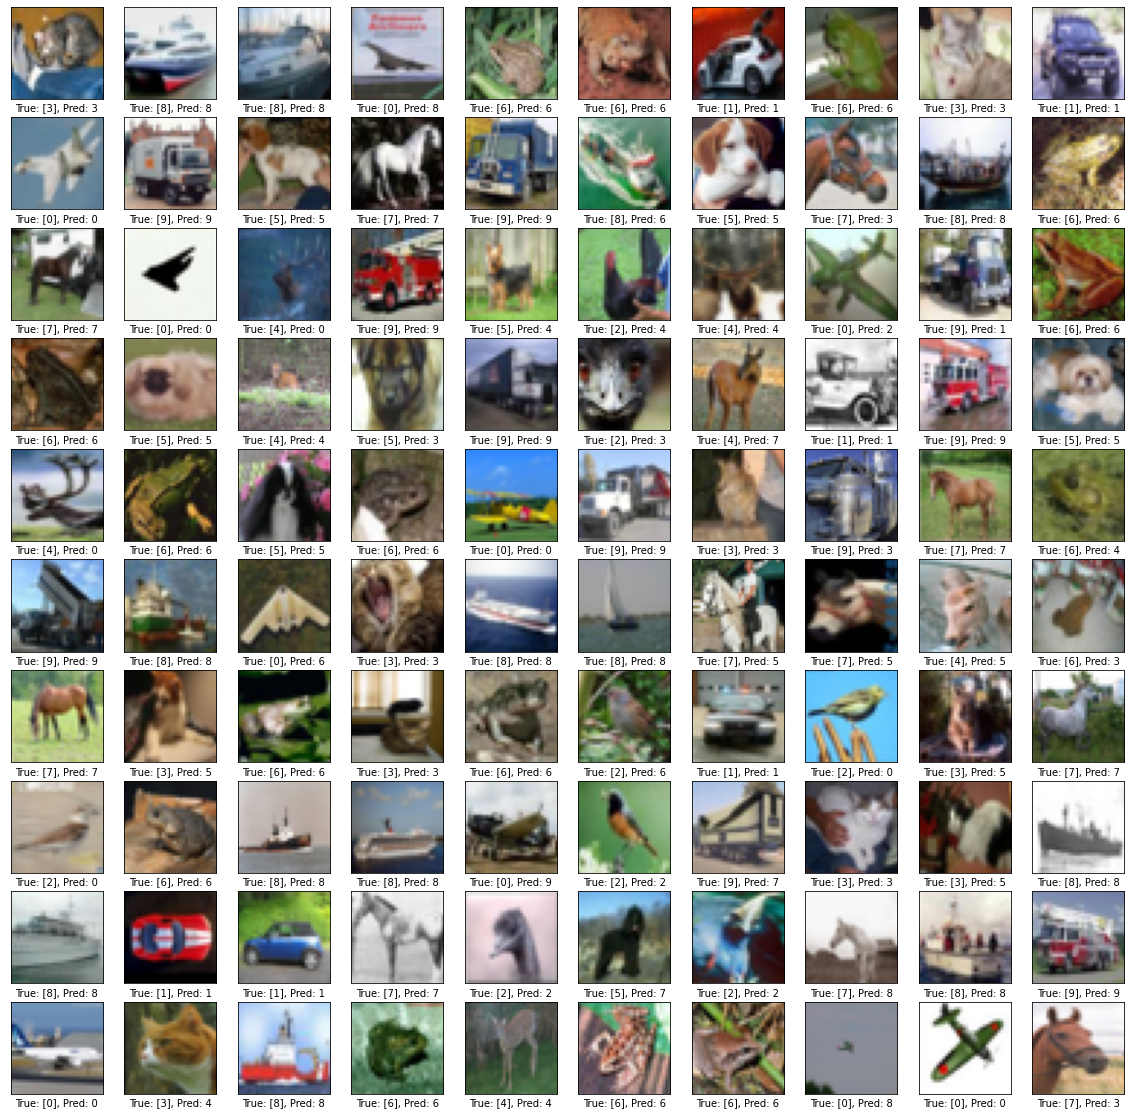

In [33]:
# Plot some predictions
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel('True: {}, Pred: {}'.format(y_test[i], label_prediction[i]))
plt.show()

In [34]:
# Get index of wrong answers
wrongAns = []
for i in range(len(y_test)):
  if y_test[i][0] != label_prediction[i]:
    wrongAns.append(i)
len(wrongAns)

3583

## Recall that `classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]`

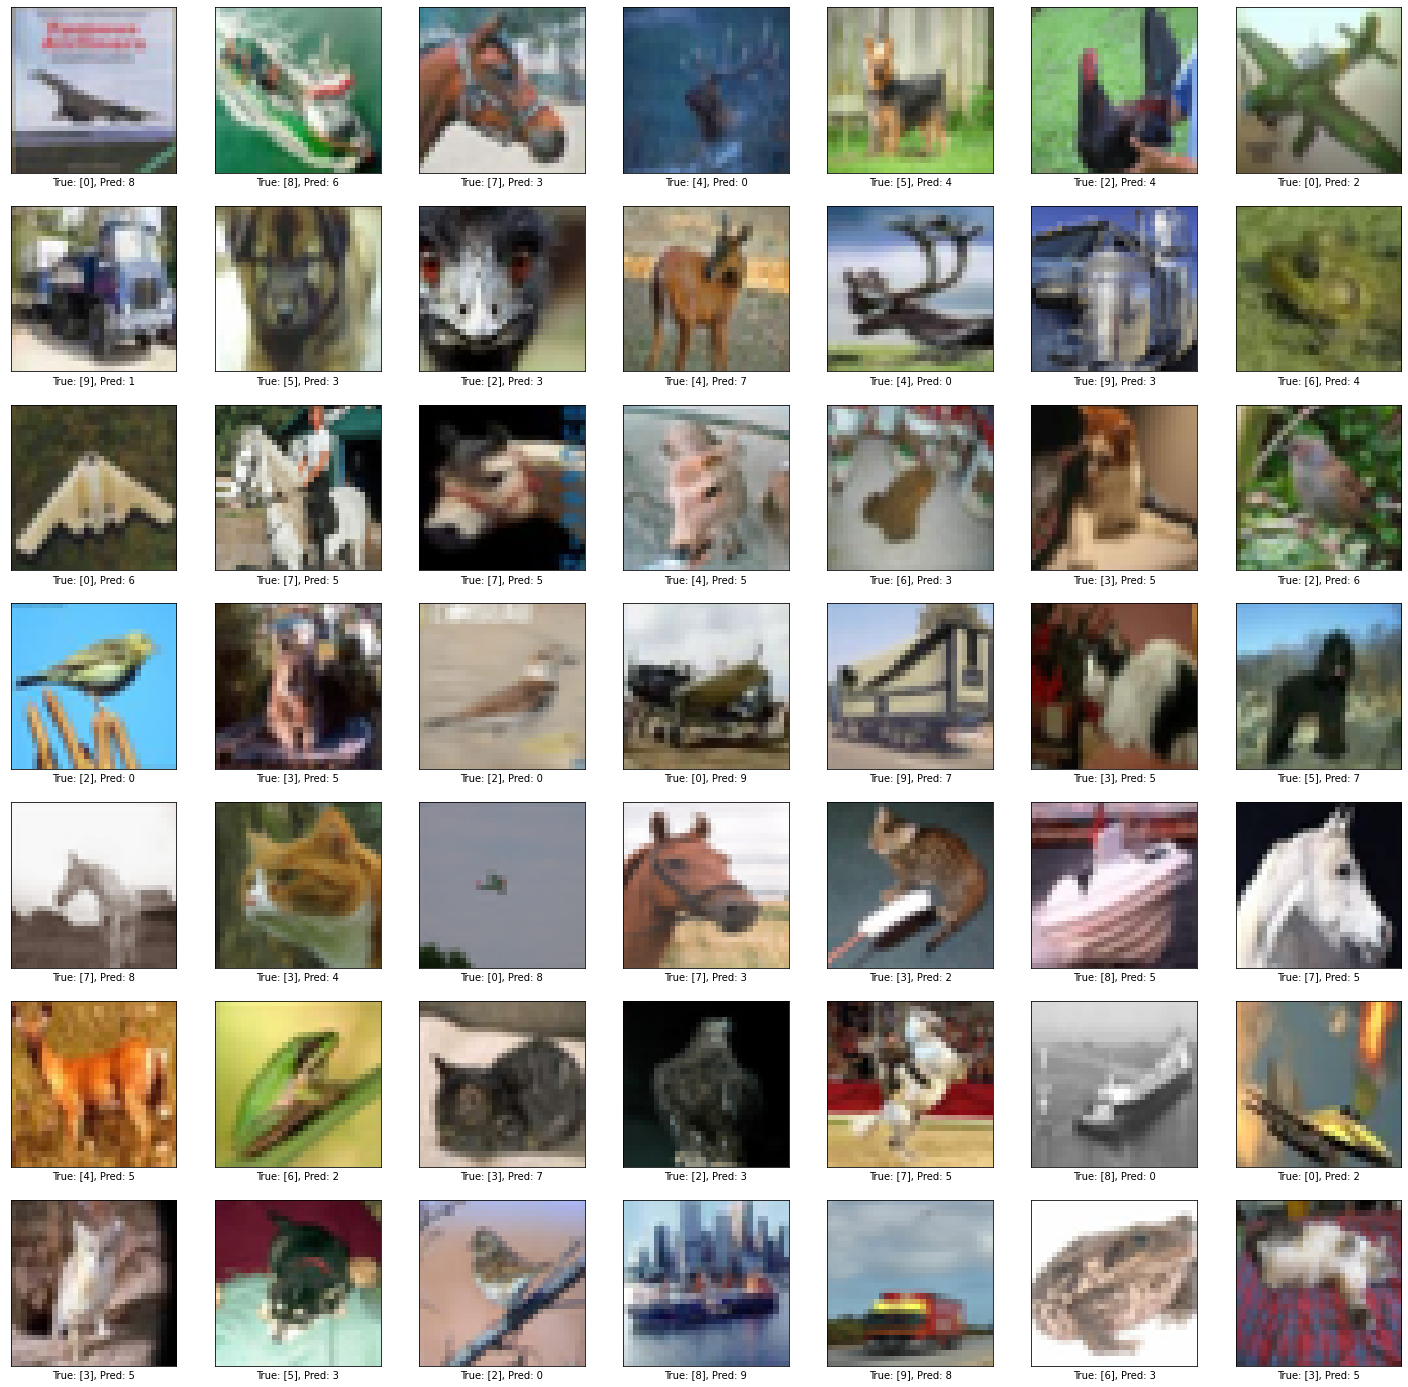

In [35]:
# Plot wrong answers
plt.figure(figsize=(25,25))
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[wrongAns[i]], cmap=plt.cm.binary)
    plt.xlabel('True: {}, Pred: {}'.format(y_test[wrongAns[i]], label_prediction[wrongAns[i]]))
plt.show()

Transfer learning  
The purpose is to take a pretrained model and run it with our data

In [36]:
def lrfn(epoch):
    """
    Learning rate callback, to maintain good lr but do not destroy the pretrained work

    Arguments:
        None
    Returns:
        next learning rate
    """
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005*8
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8

    if epoch < rampup_epochs :
        return (max_lr - start_lr)/rampup_epochs*epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs :
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=True)


In [37]:
"""
https://keras.io/api/applications/efficientnet/#efficientnetb1-function
Create pretrained model as follows:
EfficientNetB1, include_top=False, input_shape=(32, 32, 3), pooling="avg"
Dropout, 0.42
Dense, 256, tanh
Dropout, 0.42
Dense, 128, tanh
Dense, 10, softmax

Code sample: https://codelabs.developers.google.com/codelabs/keras-flowers-transfer-learning/#3
https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
"""
def create_pretrained_model():
    model = tf.keras.Sequential([
        tf.keras.applications.EfficientNetB1(include_top=False, input_shape=(32, 32, 3), pooling="avg"),
        Dropout(0.42),
        Dense(256, activation="tanh"),
        Dropout(0.42),
        Dense(128, activation="tanh"),
        Dense(10, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model
pretrained = create_pretrained_model()
pretrained.summary()


27025408/27018416 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               327936    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_25 (Dense)             (None, 10)                1290      
Total params: 6,937,361
Trainable params: 6,875,306
Non

In [ ]:
# Train the model, recall that epochs=50
history = pretrained.fit(X_train, Y_train, batch_size=32, epochs=20, 
                        validation_data=(X_valid, Y_valid), callbacks=[early_stop, lr_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
1250/1250 [==============================] - 97s 78ms/step - loss: 2.5092 - accuracy: 0.1161 - val_loss: 2.3026 - val_accuracy: 0.1641

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
1250/1250 [==============================] - 94s 76ms/step - loss: 2.0533 - accuracy: 0.2613 - val_loss: 2.4302 - val_accuracy: 0.2227

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
1250/1250 [==============================] - 94s 75ms/step - loss: 1.5444 - accuracy: 0.4559 - val_loss: 2.2329 - val_accuracy: 0.3164

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
1250/1250 [==============================] - 94s 75ms/step - loss: 1.2461 - accuracy: 0.5735 - val_loss: 2.1472 - val_accuracy: 0.3383

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/20
1250/1250 [==============================] - 94s 

In [ ]:
eval_pretrained = pretrained.evaluate(x_test, y_test)

## Tune the hyperparameters to match your desired output
### Next task: create the model to predict CIFAR 100 dataset.

In [ ]:
import tensorflow as tf
(x_train_cif100, y_train_cif100), (x_test_cif100, y_test_cif100) = tf.keras.datasets.cifar100.load_data()

In [ ]:
cif100_classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
                    'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
                    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
                    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
                    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 
                  'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
                    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [ ]:
# Show the image with the corresponding label
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(36): # Plot 36 images
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # START CODE HERE
    plt.imshow(x_train_cif100[i], cmap=plt.cm.binary) 
    plt.xlabel(cif100_classes[y_train_cif100[i][0]])
    # END CODE HERE
plt.show()

In [ ]:
"""
ImageDataGenerator: use generator to train the model. After the input is given, it will be deleted to save space.
IDG also supports image augmentation.
IDG prevents RAM overflow if converting from image to numpy is space-consuming
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, zca_whitening=True, 
                             horizontal_flip=True, vertical_flip=True, validation_split=0.2)
datagen.fit(x_train_cif100)

In [ ]:
train_flow = datagen.flow(x_train_cif100, y_train_cif100, batch_size = 32, subset="training")
valid_flow = datagen.flow(x_train_cif100, y_train_cif100, batch_size = 32, subset="validation")

In [ ]:
def create_cif100_model():
    # Create your model here
    model = None
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model_cif100 = create_cif100_model()
model_cif100.summary()

In [ ]:
def lrfn(epoch):
    """
    Learning rate callback, to maintain good lr but do not destroy the pretrained work

    Arguments:
        None
    Returns:
        next learning rate
    """
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005*8
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8

    if epoch < rampup_epochs :
        return (max_lr - start_lr)/rampup_epochs*epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs :
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr

In [ ]:
"""
EarlyStopping callback: if after n=(epochs//10), the monitor value does not increase, stop training
LearningRateScheduler: change learning rate bases on current epoch
ModelCheckpoint: save model after each epoch, but only keep the best (bases on monitor value)
"""

epochs = 100
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                              patience=epochs//10, restore_best_weights=True)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch:lrfn(epoch),
                                                       verbose=True) # Optional, if use Transfer learning
model_cp = tf.keras.callbacks.ModelCheckpoint("weight_model_cp.h5", monitor="val_loss", save_best_only=True)

In [ ]:
history = model_cif100.fit(train_flow, epochs=100, validation_data=valid_flow, callbacks=[early_stop, lr_callback, model_cp])

In [ ]:
# Plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
# Plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen.fit(x_test_cif100)
test_flow = datagen.flow(x_test, y_test, batch_size=32)

In [ ]:
# Global leaderboard: https://paperswithcode.com/sota/image-classification-on-cifar-100
prediction = model_cif100.evaluate(test_flow, steps=len(x_test_cif100)/32)